# Prompt Variant Evaluation on Click-100k

This notebook compares two prompt styles (naive vs structured) when querying **the same vision-language model** served locally via an OpenAI-compatible endpoint (`http://localhost:1234/v1`).

It measures GUI element coordinate prediction quality on samples from the `mlfoundations/Click-100k` dataset.


In [1]:
import re
import numpy as np
from PIL import Image
from datasets import load_dataset
from openai import OpenAI
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple, Dict, List
import base64
from io import BytesIO


e:\anaconda3\envs\ecua\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Setup Local Model (single endpoint)

This notebook now compares **two prompt variants** against the **same model** served locally on an OpenAI-compatible endpoint at `http://localhost:1234/v1`.

Before running the rest of the notebook, start your server (example with vLLM):

```bash
cd /root/CSE291A_ECUA3
source /root/miniconda3/etc/profile.d/conda.sh
conda activate ecua

python -m vllm.entrypoints.openai.api_server \
  --model <your_model_id> \
  --trust-remote-code \
  --port 1234 \
  --host 0.0.0.0 \
  --gpu-memory-utilization 0.40 \
  --max-num-seqs 4
```

Notes:
- Replace `<your_model_id>` with the model you want to test (the notebook will auto-discover the model id from the server if left unset).
- Only one server is needed; both prompt variants will call the same endpoint.
- If a server is already running on `localhost:1234`, you can skip the launch command.


In [2]:
# Single local model (OpenAI-compatible endpoint)
LOCAL_ENDPOINT = "http://localhost:1234/v1"
LOCAL_MODEL_ID = None  # optional override; auto-discovered if None

print("Using a single local OpenAI-compatible endpoint")
print("Note: start your server on localhost:1234 before running this cell")
print("-" * 60)

try:
    local_client = OpenAI(
        base_url=LOCAL_ENDPOINT,
        api_key="EMPTY"  # not required for local vLLM servers
    )
    available_models = local_client.models.list()
    if not getattr(available_models, "data", []):
        raise RuntimeError("No models reported by the server. Is it running on port 1234?")

    if LOCAL_MODEL_ID is None:
        LOCAL_MODEL_ID = available_models.data[0].id

    print(f"\u2713 Connection verified: available models {[m.id for m in available_models.data]}")
    print(f"\u2713 Using model id: {LOCAL_MODEL_ID}")
except Exception as e:
    raise RuntimeError(f"Failed to set up local client: {e}")


Using a single local OpenAI-compatible endpoint
Note: start your server on localhost:1234 before running this cell
------------------------------------------------------------
✓ Connection verified: available models ['ui-tars-7b-dpo', 'text-embedding-nomic-embed-text-v1.5']
✓ Using model id: ui-tars-7b-dpo


## 2. Helper Functions


In [ ]:
def image_to_base64(image: Image.Image) -> str:
    """Convert PIL Image to base64 data URL."""
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    return f"data:image/png;base64,{img_str}"


def clean_easyr1_prompt(prompt: str) -> str:
    """Remove the prefix instruction from easyr1_prompt, keeping only the actual description."""
    # The prefix that appears in easyr1_prompt before the actual description
    prefix_patterns = [
        "You are an expert UI element locator. Given a GUI image and a user's element description, provide the coordinates of the specified element as a single (x,y) point. For elements with area, return the center point.\n\nOutput the coordinate pair exactly:\n\n(x,y)",
        "You are an expert UI element locator. Given a GUI image and a user's element description, provide the coordinates of the specified element as a single (x,y) point. For elements with area, return the center point.\n\nOutput the coordinate pair exactly:\n\n(x,y)\n",
    ]
    
    for prefix in prefix_patterns:
        if prompt.startswith(prefix):
            cleaned = prompt[len(prefix):].strip()
            # Remove leading newlines and whitespace
            cleaned = cleaned.lstrip('\n').strip()
            return cleaned
    
    # If no prefix match, try to find where the actual description starts
    # Look for common patterns that indicate the start of the actual description
    if "<image>" in prompt:
        # Sometimes the prompt has <image> tag
        parts = prompt.split("<image>", 1)
        if len(parts) > 1:
            return parts[1].strip()
    
    return prompt


# Two prompt variants against the same model
PROMPT_VARIANTS = {
    "naive": (
        "Give me (x, y) coordinates of the "
        "element described below. Description: {description}\nCoordinates:"
    ),
    "structured": (
        "You are a GUI agent. Given a screenshot and a target element description, output a single (x, y) point in the screenshot for the "
        "target element. Follow these rules:\n"
        "- Focus on the element that best matches the description.\n"
        "- If the element spans an area, return its center point.\n"
        "- Output format must be exactly: (x, y)\n\n"
        "Description: {description}\n"
        "Return only the coordinate pair."
    ),
}


def build_prompted_messages(description: str, image_url: str, prompt_style: str):
    """Build OpenAI-format messages for the selected prompt variant."""
    if prompt_style not in PROMPT_VARIANTS:
        raise ValueError(f"Unknown prompt style: {prompt_style}")

    prompt_text = PROMPT_VARIANTS[prompt_style].format(description=description)
    return [
        {
            "role": "user",
            "content": [
                {"type": "image_url", "image_url": {"url": image_url}},
                {"type": "text", "text": prompt_text},
            ],
        }
    ]


def call_model_raw(
    image: Image.Image,
    query: str,
    prompt_style: str,
) -> Tuple[str, int, int]:
    """Send one screenshot + grounding query to the local endpoint."""
    orig_w, orig_h = image.size
    image_url = image_to_base64(image)
    messages = build_prompted_messages(query, image_url, prompt_style)

    try:
        response = local_client.chat.completions.create(
            model=LOCAL_MODEL_ID,
            messages=messages,
            max_tokens=128,
            temperature=0.0,
        )
        reply = response.choices[0].message.content.strip()
    except Exception as e:
        print(f"API call error: {e}")
        reply = ""

    return reply, orig_w, orig_h


def parse_xy_from_string(text: str) -> Tuple[int, int]:
    """
    Extract (x, y) coordinates from a string.
    Handles various formats:
    - (x, y) - two coordinates
    - (x1, y1, x2, y2) - four coordinates (bbox), computes center
    - Multiple coordinate pairs - takes the first valid one
    """
    if not text or not text.strip():
        raise ValueError("Empty text provided")

    text = text.strip()
    pattern_two = re.findall(r"\(\s*(\d+)\s*,\s*(\d+)\s*\)", text)
    pattern_four = re.findall(r"\(\s*(\d+)\s*,\s*(\d+)\s*,\s*(\d+)\s*,\s*(\d+)\s*\)", text)

    if pattern_two:
        for match in pattern_two:
            x, y = int(match[0]), int(match[1])
            if 0 <= x < 1000 and 0 <= y < 1000:
                return x, y

    if pattern_four:
        for match in pattern_four:
            x1, y1, x2, y2 = int(match[0]), int(match[1]), int(match[2]), int(match[3])
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2
            if 0 <= center_x < 1000 and 0 <= center_y < 1000:
                return center_x, center_y
            elif 0 <= x1 < 1000 and 0 <= y1 < 1000:
                return x1, y1

    numbers = re.findall(r"\d+", text)
    if len(numbers) >= 2:
        x, y = int(numbers[0]), int(numbers[1])
        x = max(0, min(999, x))
        y = max(0, min(999, y))
        return x, y

    raise ValueError(f"Could not parse valid coordinates from: {text[:200]!r}")


def scale_to_pixels(x_1000: int, y_1000: int, width: int, height: int) -> Tuple[int, int]:
    """Map model coordinates in [0,1000) to pixel coordinates."""
    x_px = int(x_1000 / 1000 * width)
    y_px = int(y_1000 / 1000 * height)
    x_px = max(0, min(width - 1, x_px))
    y_px = max(0, min(height - 1, y_px))
    return x_px, y_px


def predict_coordinates(
    image: Image.Image,
    query: str,
    prompt_style: str,
) -> Tuple[int, int, str]:
    """
    Predict coordinates using the selected prompt variant on the local model.
    Returns: (x_px, y_px, raw_response)
    """
    reply, orig_w, orig_h = call_model_raw(image, query, prompt_style)

    if not reply or reply.strip() == "":
        return orig_w // 2, orig_h // 2, reply

    try:
        x_1000, y_1000 = parse_xy_from_string(reply)
        x_px, y_px = scale_to_pixels(x_1000, y_1000, orig_w, orig_h)
        return x_px, y_px, reply
    except ValueError as e:
        if reply.strip():
            print(f"Warning: Failed to parse coordinates ({prompt_style}): {e}, reply: {reply[:50]}")
        return orig_w // 2, orig_h // 2, reply


def euclidean_distance(x1: int, y1: int, x2: int, y2: int) -> float:
    """Calculate Euclidean distance between two points."""
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)


def bbox_to_center(bbox: List[int]) -> Tuple[int, int]:
    """Convert bounding box [x1, y1, x2, y2] to center coordinates (x, y)."""
    if len(bbox) != 4:
        raise ValueError(f"Bbox must have 4 elements, got {len(bbox)}")
    x1, y1, x2, y2 = bbox
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2
    return center_x, center_y


## 3. Load Click-100k Dataset


In [4]:
print("Loading Click-100k dataset...")
dataset = load_dataset("mlfoundations/Click-100k", split="train[:100]")
print(f"Total samples in dataset: {len(dataset)}")

# Take first 100 samples
eval_dataset = dataset.select(range(min(100, len(dataset))))
print(f"Evaluating on {len(eval_dataset)} samples")
print(f"\nDataset features: {eval_dataset.features}")
print(f"\nSample keys: {eval_dataset[0].keys()}")


Loading Click-100k dataset...
Total samples in dataset: 100
Evaluating on 100 samples

Dataset features: {'image_path': Value('string'), 'images': List(Image(mode=None, decode=True)), 'easyr1_prompt': Value('string'), 'bbox': List(Value('int64')), 'image_width': Value('int64'), 'image_height': Value('int64'), 'normalized_bbox': List(Value('float64'))}

Sample keys: dict_keys(['image_path', 'images', 'easyr1_prompt', 'bbox', 'image_width', 'image_height', 'normalized_bbox'])


## 4. Run Evaluation


In [8]:
# Initialize results storage per prompt variant
results = {style: [] for style in PROMPT_VARIANTS.keys()}

print("Running evaluation (same model, different prompts)...")
for idx in tqdm(range(len(eval_dataset)), desc="Processing samples"):
    sample = eval_dataset[idx]
    
    images_list = sample.get("images")
    if images_list is None or len(images_list) == 0:
        print(f"Skipping sample {idx}: no images found")
        continue
    
    image = images_list[0]
    if not isinstance(image, Image.Image):
        if hasattr(image, "convert"):
            image = image.convert("RGB")
        else:
            print(f"Skipping sample {idx}: cannot process image format")
            continue
    
    raw_query = sample.get("easyr1_prompt")
    if raw_query is None:
        print(f"Skipping sample {idx}: missing query")
        continue
    
    # Clean the query by removing the instruction prefix
    query = clean_easyr1_prompt(raw_query)
    
    bbox = sample.get("bbox")
    if bbox is None or len(bbox) != 4:
        print(f"Skipping sample {idx}: invalid bbox {bbox}")
        continue
    
    try:
        gt_x, gt_y = bbox_to_center(bbox)
    except Exception as e:
        print(f"Skipping sample {idx}: error converting bbox: {e}")
        continue
    
    # Evaluate both prompt variants on the same model
    for prompt_style in PROMPT_VARIANTS.keys():
        try:
            pred_x, pred_y, raw_response = predict_coordinates(image, query, prompt_style)
            distance = euclidean_distance(pred_x, pred_y, gt_x, gt_y)
            
            results[prompt_style].append({
                "sample_idx": idx,
                "query": query,
                "bbox": bbox,
                "gt_x": gt_x,
                "gt_y": gt_y,
                "pred_x": pred_x,
                "pred_y": pred_y,
                "distance": distance,
                "raw_response": raw_response,
                "prompt_style": prompt_style,
            })
        except Exception as e:
            print(f"Error processing sample {idx} with {prompt_style}: {e}")
            results[prompt_style].append({
                "sample_idx": idx,
                "query": query,
                "bbox": bbox,
                "gt_x": gt_x,
                "gt_y": gt_y,
                "pred_x": None,
                "pred_y": None,
                "distance": float('inf'),
                "raw_response": str(e),
                "error": True,
                "prompt_style": prompt_style,
            })

print("\nEvaluation complete!")


Running evaluation (same model, different prompts)...


Processing samples: 100%|██████████| 100/100 [09:01<00:00,  5.41s/it]


Evaluation complete!


## Legacy UI-TARS Section (disabled)

The notebook now focuses on comparing two prompt variants against a single local model on `localhost:1234`. The previous UI-TARS instructions are no longer needed. You can safely skip this section.

In [ ]:
# Legacy UI-TARS evaluation placeholder (disabled)
print("UI-TARS evaluation disabled: notebook now compares prompt variants on a single local model @ localhost:1234.")


Running UI-TARS-1.5-7B evaluation...


Processing samples (ui-tars-7b):   0%|          | 0/1000 [00:00<?, ?it/s]

Processing samples (ui-tars-7b): 100%|██████████| 1000/1000 [18:07<00:00,  1.09s/it]


UI-TARS-1.5-7B evaluation complete!


## 5. Calculate Metrics


In [9]:
def calculate_metrics(results: List[Dict]) -> Dict:
    """Calculate evaluation metrics."""
    valid = [r for r in results if r.get("distance") != float('inf')]
    distances = [r["distance"] for r in valid]

    # In-bbox accuracy: predicted point lies inside the GT bbox
    in_bbox_hits = 0
    for r in valid:
        bbox = r.get("bbox")
        px, py = r.get("pred_x"), r.get("pred_y")
        if bbox is None or px is None or py is None or len(bbox) != 4:
            continue
        x1, y1, x2, y2 = bbox
        lx, rx = min(x1, x2), max(x1, x2)
        ly, ry = min(y1, y2), max(y1, y2)
        if lx <= px <= rx and ly <= py <= ry:
            in_bbox_hits += 1

    if not distances:
        return {
            "mean_distance": float('inf'),
            "median_distance": float('inf'),
            "std_distance": float('inf'),
            "accuracy_5px": 0.0,
            "accuracy_10px": 0.0,
            "accuracy_20px": 0.0,
            "accuracy_50px": 0.0,
            "accuracy_bbox": 0.0,
            "total_samples": len(results),
            "successful_samples": 0,
        }

    distances = np.array(distances)

    thresholds = [5, 10, 20, 50]
    accuracies = {}
    for threshold in thresholds:
        accuracies[f"accuracy_{threshold}px"] = np.mean(distances <= threshold) * 100

    return {
        "mean_distance": float(np.mean(distances)),
        "median_distance": float(np.median(distances)),
        "std_distance": float(np.std(distances)),
        **accuracies,
        "accuracy_bbox": (in_bbox_hits / len(valid)) * 100 if valid else 0.0,
        "total_samples": len(results),
        "successful_samples": len(distances),
    }

# Calculate metrics for both prompt variants
metrics = {}
for prompt_style in PROMPT_VARIANTS.keys():
    metrics[prompt_style] = calculate_metrics(results[prompt_style])
    print(f"\n{prompt_style.upper()} PROMPT Metrics:")
    print(f"  Mean Distance Error: {metrics[prompt_style]['mean_distance']:.2f} px")
    print(f"  Median Distance Error: {metrics[prompt_style]['median_distance']:.2f} px")
    print(f"  Std Distance Error: {metrics[prompt_style]['std_distance']:.2f} px")
    print(f"  Accuracy @ 5px: {metrics[prompt_style]['accuracy_5px']:.2f}%")
    print(f"  Accuracy @ 10px: {metrics[prompt_style]['accuracy_10px']:.2f}%")
    print(f"  Accuracy @ 20px: {metrics[prompt_style]['accuracy_20px']:.2f}%")
    print(f"  Accuracy @ 50px: {metrics[prompt_style]['accuracy_50px']:.2f}%")
    print(f"  In-BBox Accuracy: {metrics[prompt_style]['accuracy_bbox']:.2f}%")
    print(f"  Successful Predictions: {metrics[prompt_style]['successful_samples']}/{metrics[prompt_style]['total_samples']}")



NAIVE PROMPT Metrics:
  Mean Distance Error: 136.88 px
  Median Distance Error: 34.51 px
  Std Distance Error: 208.30 px
  Accuracy @ 5px: 9.00%
  Accuracy @ 10px: 19.00%
  Accuracy @ 20px: 32.00%
  Accuracy @ 50px: 58.00%
  In-BBox Accuracy: 32.00%
  Successful Predictions: 100/100

STRUCTURED PROMPT Metrics:
  Mean Distance Error: 154.65 px
  Median Distance Error: 33.98 px
  Std Distance Error: 256.03 px
  Accuracy @ 5px: 10.00%
  Accuracy @ 10px: 18.00%
  Accuracy @ 20px: 35.00%
  Accuracy @ 50px: 60.00%
  In-BBox Accuracy: 34.00%
  Successful Predictions: 100/100


## 6. Comparison Table


In [10]:
# Create comparison DataFrame (prompt variants on the same model)
comparison_data = []
for prompt_style in PROMPT_VARIANTS.keys():
    m = metrics[prompt_style]
    comparison_data.append({
        "Prompt Variant": prompt_style,
        "Mean Distance (px)": f"{m['mean_distance']:.2f}",
        "Median Distance (px)": f"{m['median_distance']:.2f}",
        "Std Distance (px)": f"{m['std_distance']:.2f}",
        "Accuracy @ 5px (%)": f"{m['accuracy_5px']:.2f}",
        "Accuracy @ 10px (%)": f"{m['accuracy_10px']:.2f}",
        "Accuracy @ 20px (%)": f"{m['accuracy_20px']:.2f}",
        "Accuracy @ 50px (%)": f"{m['accuracy_50px']:.2f}",
        "In-BBox Accuracy (%)": f"{m['accuracy_bbox']:.2f}",
        "Success Rate": f"{m['successful_samples']}/{m['total_samples']}",
    })

df_comparison = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("PROMPT COMPARISON (same model @ localhost:1234)")
print("="*80)
print(df_comparison.to_string(index=False))
print("="*80)



PROMPT COMPARISON (same model @ localhost:1234)
Prompt Variant Mean Distance (px) Median Distance (px) Std Distance (px) Accuracy @ 5px (%) Accuracy @ 10px (%) Accuracy @ 20px (%) Accuracy @ 50px (%) In-BBox Accuracy (%) Success Rate
         naive             136.88                34.51            208.30               9.00               19.00               32.00               58.00                32.00      100/100
    structured             154.65                33.98            256.03              10.00               18.00               35.00               60.00                34.00      100/100


## 7. Visualization


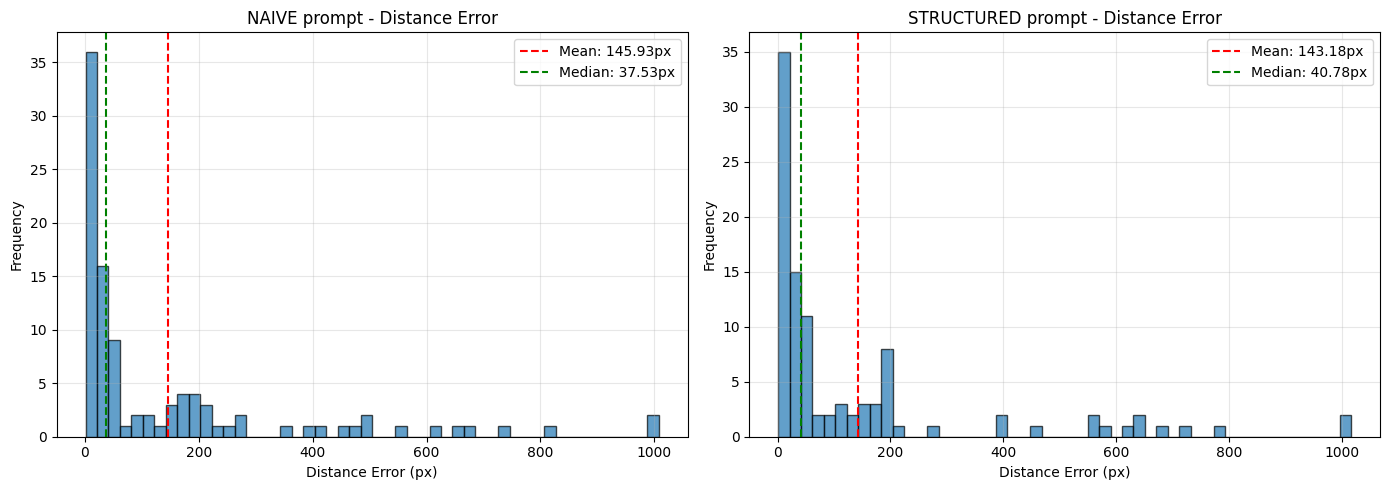

In [9]:
# Plot distance distributions per prompt style
fig, axes = plt.subplots(1, len(PROMPT_VARIANTS), figsize=(7 * len(PROMPT_VARIANTS), 5))
if len(PROMPT_VARIANTS) == 1:
    axes = [axes]

for idx, prompt_style in enumerate(PROMPT_VARIANTS.keys()):
    distances = [r["distance"] for r in results[prompt_style] 
                 if r.get("distance") != float('inf')]
    
    if distances:
        axes[idx].hist(distances, bins=50, alpha=0.7, edgecolor='black')
        axes[idx].axvline(np.mean(distances), color='red', linestyle='--', 
                         label=f'Mean: {np.mean(distances):.2f}px')
        axes[idx].axvline(np.median(distances), color='green', linestyle='--', 
                         label=f'Median: {np.median(distances):.2f}px')
        axes[idx].set_xlabel('Distance Error (px)')
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(f'{prompt_style.upper()} prompt - Distance Error')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    else:
        axes[idx].text(0.5, 0.5, 'No valid predictions', 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f'{prompt_style.upper()} prompt - No Data')

plt.tight_layout()
plt.show()


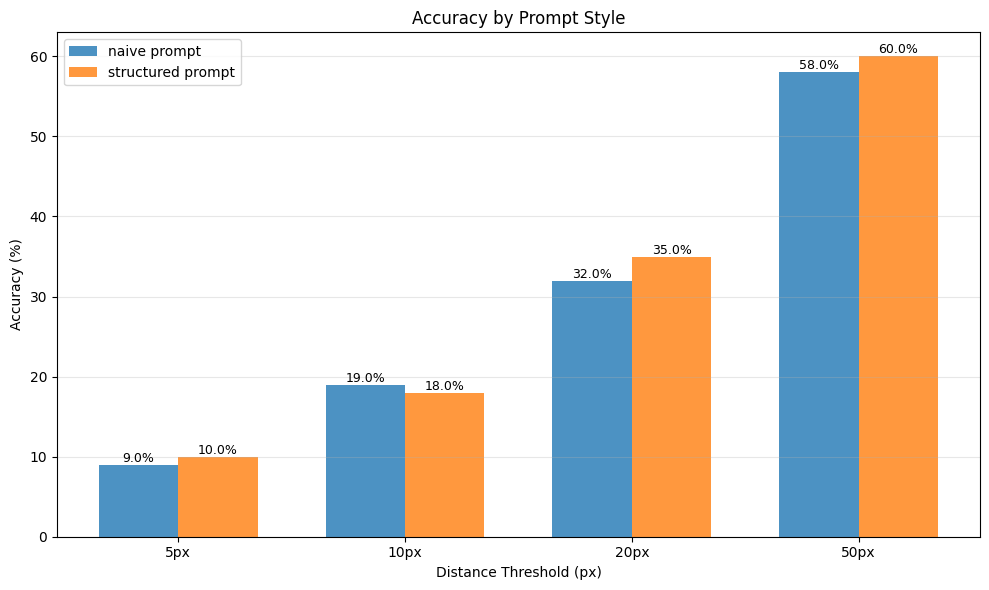

In [11]:
# Plot accuracy comparison between prompt variants
fig, ax = plt.subplots(figsize=(10, 6))

thresholds = [5, 10, 20, 50]
x = np.arange(len(thresholds))
width = 0.35
prompt_styles = list(PROMPT_VARIANTS.keys())

acc_values = {
    style: [metrics[style][f"accuracy_{t}px"] for t in thresholds]
    for style in prompt_styles
}

bars = []
for i, style in enumerate(prompt_styles):
    offset = (i - (len(prompt_styles) - 1) / 2) * width
    bars.append(
        ax.bar(x + offset, acc_values[style], width, label=f"{style} prompt", alpha=0.8)
    )

ax.set_xlabel('Distance Threshold (px)')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy by Prompt Style')
ax.set_xticks(x)
ax.set_xticklabels([f'{t}px' for t in thresholds])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for bar_group in bars:
    for bar in bar_group:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## 8. Sample Predictions


In [ ]:
# Show some example predictions
num_examples = min(5, len(eval_dataset))
print(f"\nShowing {num_examples} example predictions:\n")

for idx in range(num_examples):
    sample = eval_dataset[idx]
    images_list = sample.get("images")
    raw_query = sample.get("easyr1_prompt")
    bbox = sample.get("bbox")
    
    if images_list is None or len(images_list) == 0 or raw_query is None or bbox is None:
        continue
    
    # Clean the query by removing the instruction prefix
    query = clean_easyr1_prompt(raw_query)
    
    image = images_list[0]
    if not isinstance(image, Image.Image):
        if hasattr(image, "convert"):
            image = image.convert("RGB")
        else:
            continue
    
    try:
        gt_x, gt_y = bbox_to_center(bbox)
    except:
        continue
    
    print(f"\n{'='*80}")
    print(f"Example {idx + 1}")
    print(f"{'='*80}")
    print(f"Query: {query}")
    print(f"Bbox: {bbox}")
    print(f"Ground Truth Center: ({gt_x}, {gt_y})")
    
    for prompt_style in PROMPT_VARIANTS.keys():
        # Find the result for this sample index
        result = None
        for r in results[prompt_style]:
            if r.get("sample_idx") == idx:
                result = r
                break
        
        if result is None:
            print(f"\n{prompt_style}: No result found")
            continue
            
        if result.get("error"):
            print(f"\n{prompt_style}: ERROR - {result['raw_response']}")
        else:
            print(f"\n{prompt_style} prompt:")
            print(f"  Ground Truth: ({result['gt_x']}, {result['gt_y']})")
            print(f"  Predicted: ({result['pred_x']}, {result['pred_y']})")
            print(f"  Distance Error: {result['distance']:.2f} px")
            print(f"  Raw Response: {result['raw_response']}")



Showing 5 example predictions:


Example 1
Query: You are an expert UI element locator. Given a GUI image and a user's element description, provide the coordinates of the specified element as a single (x,y) point. For elements with area, return the center point.

Output the coordinate pair exactly:
(x,y)

<image>
Tap on Located between 'Background' and 'Notifications' options.
Bbox: [72, 183, 322, 232]
Ground Truth Center: (197, 207)

uground-2b:
  Ground Truth: (197, 207)
  Predicted: (190, 164)
  Distance Error: 43.57 px
  Raw Response: (97, 151)

qwen2-vl-2b:
  Ground Truth: (197, 207)
  Predicted: (0, 1)
  Distance Error: 285.04 px
  Raw Response: (0, 1)

Example 2
Query: You are an expert UI element locator. Given a GUI image and a user's element description, provide the coordinates of the specified element as a single (x,y) point. For elements with area, return the center point.

Output the coordinate pair exactly:
(x,y)

<image>
I will give textual descriptions of a certain ele